<h1>KNN-Based Classification of Spinal Conditions in the Vertebral Column Data Set</h1>

<h5>This project involves the analysis and classification of the Vertebral Column Data Set using various K-Nearest Neighbors (KNN) techniques. The data set, collected by Dr. Henrique da Mota, consists of six biomechanical attributes from each patient, focusing on the binary classification of normal (NO) and abnormal (AB) spinal conditions. The project encompasses data preprocessing, exploratory data analysis, KNN classification with different metrics, and an investigation into weighted voting techniques. The objective is to determine the most effective KNN approach for this classification task, evaluating performance through metrics such as confusion matrices, true positive/negative rates, precision, and F1-score.</h5>

###  Data Acquisition

- Source: Vertebral Column Data Set
- Task: Binary classification (Normal = 0, Abnormal = 1)

Package imports

In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score

Get the Vertebral Column Data Set

In [2]:
# Read in the ARFF file & load directly to DataFrame
raw_data = arff.loadarff('../data/vertebral_column_data/column_2C_weka.arff')
df_raw = pd.DataFrame(raw_data[0])

# Get indicator columns
df = pd.get_dummies(df_raw, columns=['class'])

# convert the normal/abnormal label to dummy variables 0 and 1
df = pd.get_dummies(df_raw, columns=['class'])
df.rename(columns = {'class_b\'Abnormal\'':'class'}, inplace = True)
df.drop('class_b\'Normal\'', axis=1, inplace=True)
df['class'] = np.where(df['class'], 1, 0)

# display the dataframe
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,0
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,0
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,0
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,0


### Pre-Processing and Exploratory Data Analysis

- Scatterplots: Visualize independent variables with color-coded classes.
- Boxplots: Create for each independent variable, distinguishing classes 0 and 1.
- Data Split: First 70 rows of Class 0 and first 140 rows of Class 1 as training set; the rest as the test set.

Scatterplots

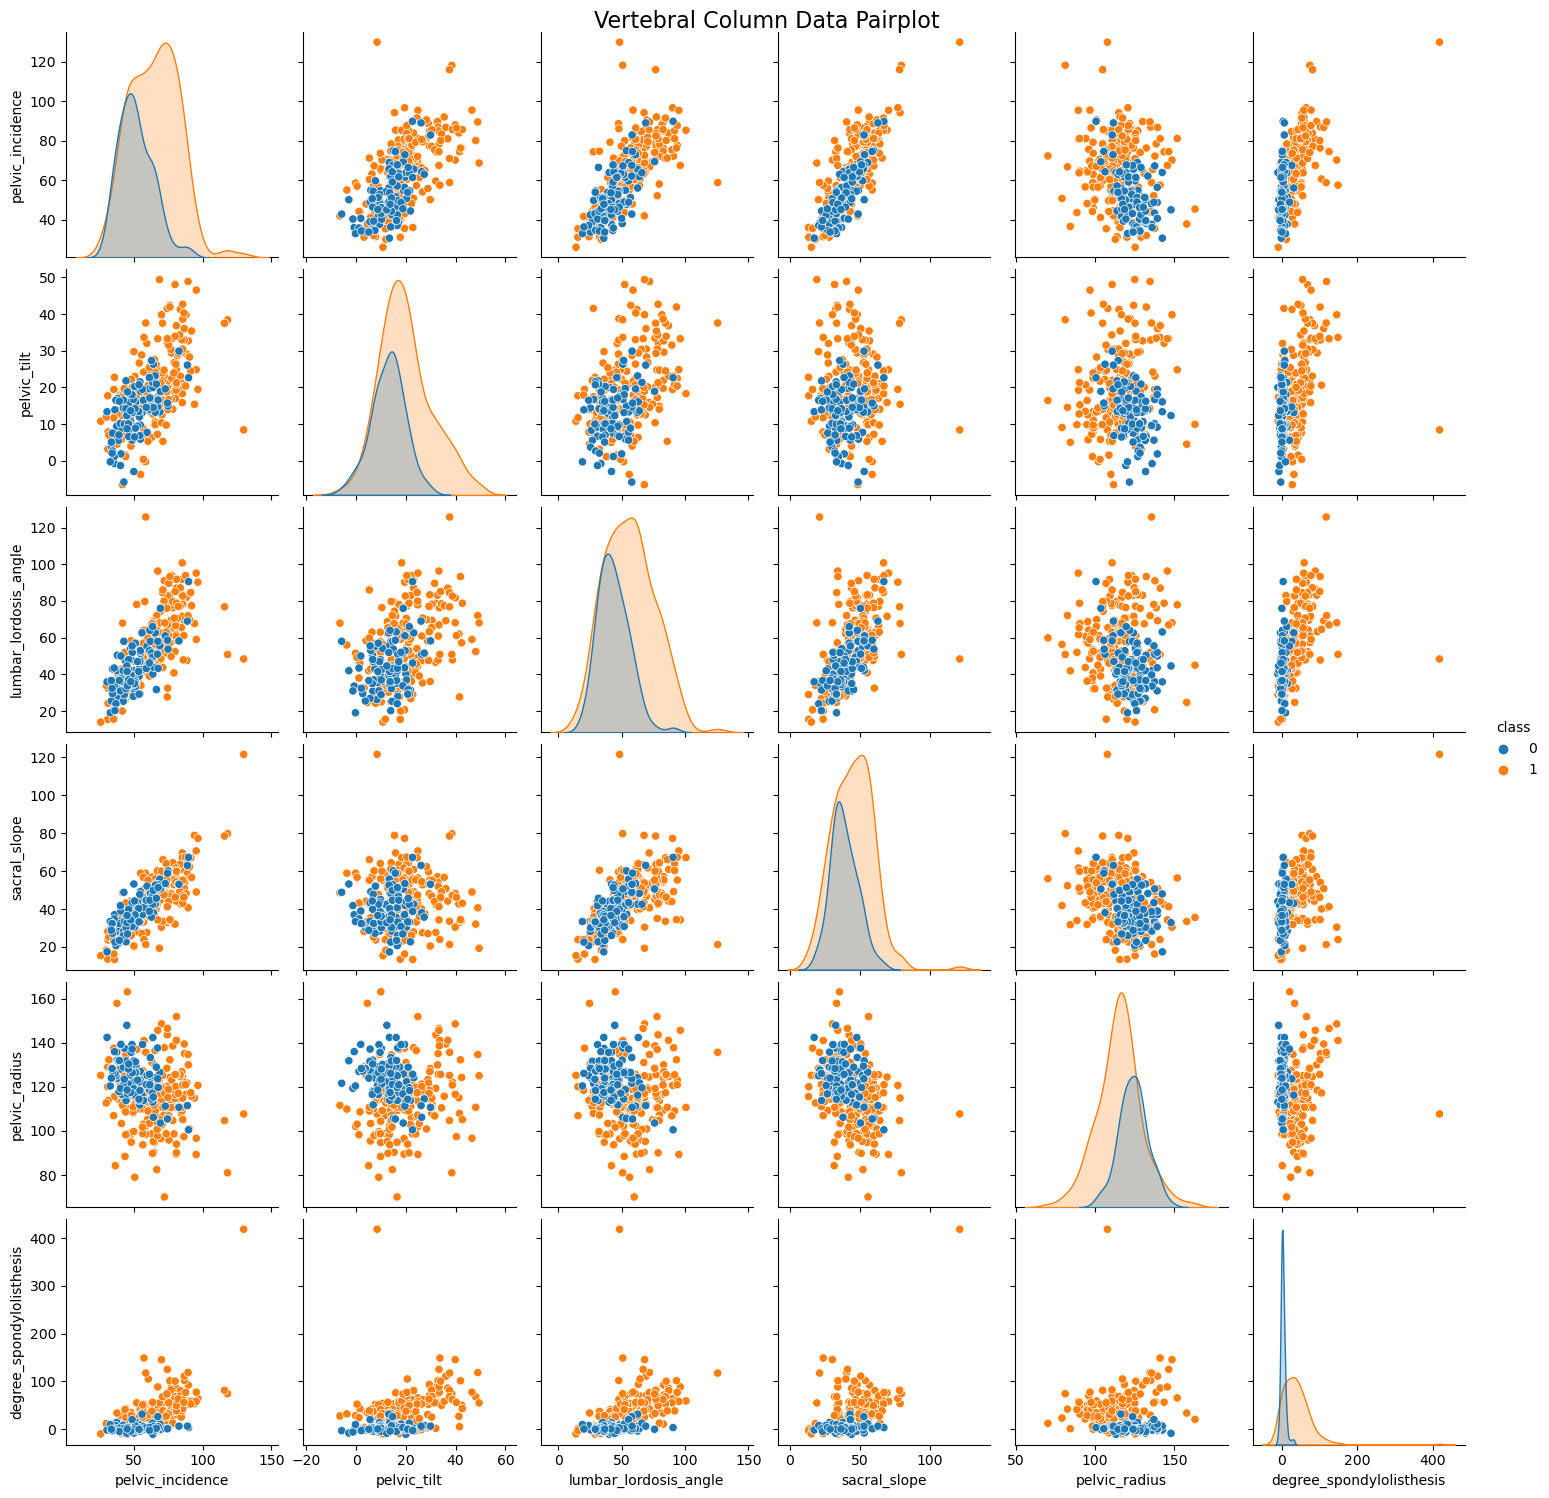

In [3]:
# Make scatterplots of the independent variables in the dataset. Use color to show Classes 0 and 1.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')   
    sns.pairplot(df, hue='class', diag_kind='kde')
    plt.suptitle('Vertebral Column Data Pairplot', y=1, fontsize=16)
    plt.show()

Boxplots

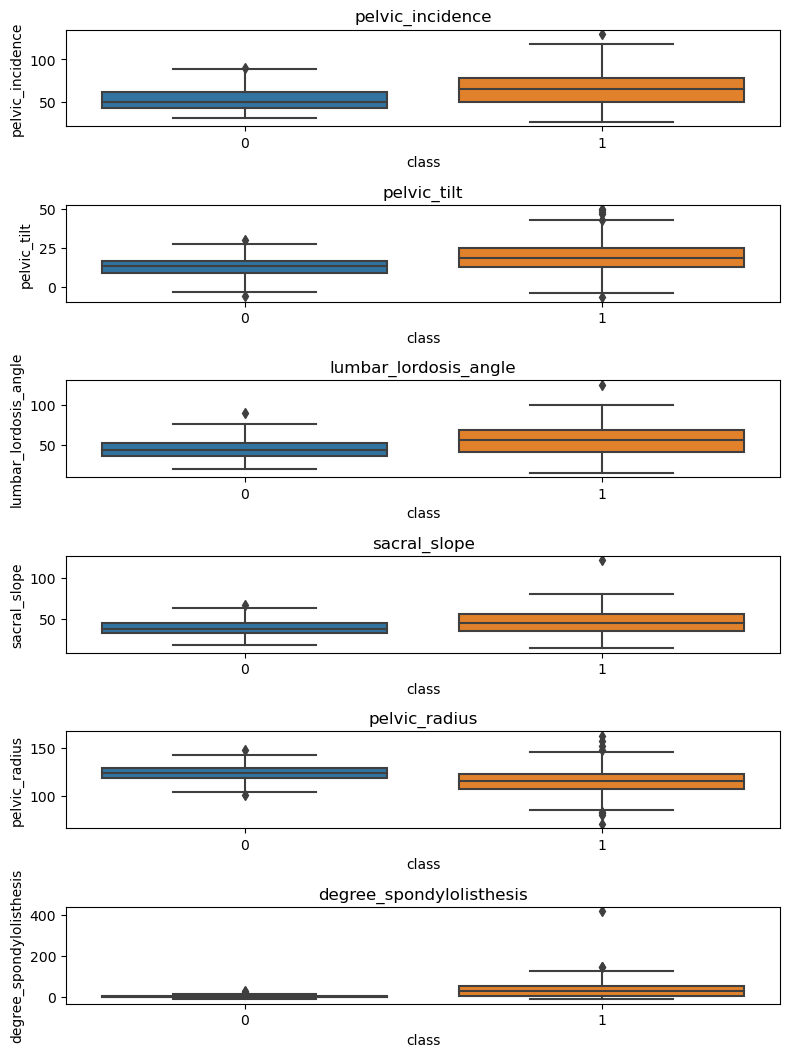

In [4]:
# Make boxplots for each of the independent variables. Use color to show Classes 0 and 1
# Get numeric columns  
num_cols = df.select_dtypes('number').columns

# Create boxplots
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    fig, axs = plt.subplots(nrows=len(num_cols), figsize=(8, 12))
    
    for i, col in enumerate(num_cols):
        # Boxplot with class color    
        sns.boxplot(x='class', y=col, data=df, ax=axs[i])
        # Add column name as title
        axs[i].set_title(col) 
    
    # Remove last subplot    
    fig.delaxes(axs[-1]) 
    plt.tight_layout()
    plt.show()

Split Data Set

In [5]:
# Select the first 70 rows of Class 0 and the first 140 rows of Class 1 as the 
# training set and the rest of the data as the test set.
train_class0 = df[df['class'] == 0].iloc[:70]
train_class1 = df[df['class'] == 1].iloc[:140]

test_class0 = df[df['class'] == 0].tail(n=len(df[df['class'] == 0])-70)
test_class1 = df[df['class'] == 1].tail(n=len(df[df['class'] == 1])-140)

# Concatenate training sets
train_df = pd.concat([train_class0, train_class1],ignore_index = True)
test_df = pd.concat([test_class0, test_class1], ignore_index = True)

# Print shapes
print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Training data shape: (210, 7)
Test data shape: (100, 7)


In [6]:
# print train dataset
train_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,38.505273,16.964297,35.112814,21.540976,127.632875,7.986683,0
1,54.920858,18.968430,51.601455,35.952428,125.846646,2.001642,0
2,44.362490,8.945435,46.902096,35.417055,129.220682,4.994195,0
3,48.318931,17.452121,48.000000,30.866809,128.980308,-0.910941,0
4,45.701789,10.659859,42.577846,35.041929,130.178314,-3.388910,0
...,...,...,...,...,...,...,...
205,77.121344,30.349874,77.481083,46.771470,110.611148,82.093607,1
206,88.024499,39.844669,81.774473,48.179830,116.601538,56.766083,1
207,83.396606,34.310989,78.423293,49.085617,110.466516,49.672096,1
208,72.054034,24.700737,79.874016,47.353297,107.172358,56.426159,1


In [7]:
# print test dataset
test_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,50.086153,13.430044,34.457541,36.656108,119.134622,3.089484,0
1,64.261507,14.497866,43.902504,49.763642,115.388268,5.951454,0
2,53.683380,13.447022,41.584297,40.236358,113.913703,2.737035,0
3,48.995958,13.113820,51.873520,35.882137,126.398188,0.535472,0
4,59.167612,14.562749,43.199158,44.604863,121.035642,2.830504,0
...,...,...,...,...,...,...,...
95,80.111572,33.942432,85.101608,46.169139,125.593624,100.292107,1
96,95.480229,46.550053,59.000000,48.930176,96.683903,77.283072,1
97,74.094731,18.823727,76.032156,55.271004,128.405731,73.388216,1
98,87.679087,20.365613,93.822416,67.313473,120.944829,76.730629,1


### Classification using KNN

- Implement KNN with Euclidean metric.
- Test data with majority polling, analyzing train and test errors for varying k values.
- Optimal k (k*): Determine through analysis; calculate confusion matrix, rates, precision, and F1-score at k*.
- Learning Curve: Plot best test error rate against training set size.

Euclidean Metric

In [8]:
# Write code for k-nearest neighbors with Euclidean metric (or use a software package).

# variables and classes for the training set and testing set
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

Test Data

The best k is k = 4
The following metrics are calculated using the best K.
Confusion Matrix:
[[25  5]
 [ 1 69]]
True Positive Rate: 0.9857142857142858
True Negative Rate: 0.8333333333333334
Precision: 0.9324324324324325
F1 Score: 0.9583333333333333


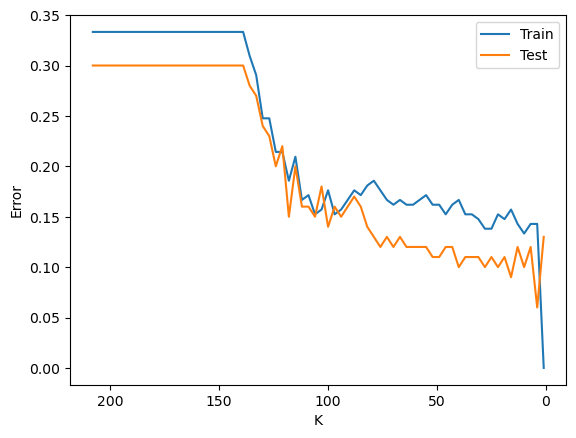

In [13]:
# Test all the data in the test database with k nearest neighbors. Take decisions by majority polling. 
# Plot train and test errors in terms of k for k belong to {208,205,...,7,4,1} (in reverse order).
# Train KNN model7
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

train_errors = []
test_errors = []

for k in range(208, 0, -3):
    knn.n_neighbors = k
    # Calculate error on train and test set
    train_errors.append(1 - knn.score(X_train, y_train)) 
    test_errors.append(1 - knn.score(X_test, y_test))

# Plot train and test error vs K (in reverse order) 
k_vals = list(range(208, 0, -3))
plt.plot(k_vals, train_errors, label='Train')
plt.plot(k_vals, test_errors, label='Test')
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1]) 
plt.legend()
plt.xlabel('K')
plt.ylabel('Error')



# Which k  is the most suitable k among those values? 
# Get best K value
k_range = range(208, 0, -3)
best_k = k_range[np.argmin(test_errors)] 
print("The best k is k =", best_k)



# Refit model with best K and make predictions
knn.n_neighbors = best_k
knn.fit(X_train, y_train) 
y_pred = knn.predict(X_test)

# Calculate the confusion matrix, true positive rate, true negative rate, precision, and F1-score using the best K
print("The following metrics are calculated using the best K.")
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
# True positive rate
TP = cm[1][1]/ (cm[1][1]+cm[1][0])
# True negative rate
TN = cm[0][0]/ (cm[0][0]+cm[0][1])
# Precision 
precision = precision_score(y_test, y_pred)
# F1-score
f1 = f1_score(y_test, y_pred)

# print the metrics
print("Confusion Matrix:")
print(cm)
print("True Positive Rate:", TP)
print("True Negative Rate:", TN)
print("Precision:", precision)
print("F1 Score:", f1)

Learning Curve

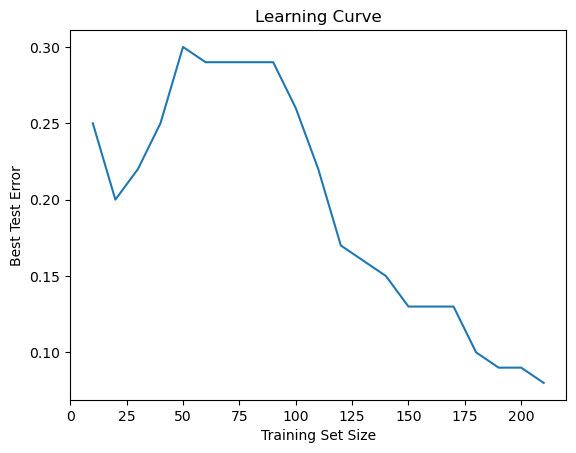

In [14]:
# Since the computation time depends on the size of the training set, one may only use a subset of the training set. 
# Plot the best test error rate, which is obtained by some value of k, against the size of training set, when the size of training set is N belongs to {10,20,30,...,210}. 
# Note: for each N, select the training set by choosing the first [N/3] rows of Class 0 and the first N - [N/3] rows of Class 1 in the training set created. 
# Also, for each N, select the optimal k from a set starting from k = 1, increasing by 5. For example, if N = 200, the optimal k is selected from {1,6,11,...,196}.
# This plot is called a Learning Curve.

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    # setup an empty list for the best test errors and a range of sizes (N) for the training set 
    best_test_errors = []
    best_k = []
    train_sizes = range(10, 220, 10)
    
    for N in train_sizes:
    
        # Get N/3 rows from class 0 and N - N/3 rows from class 1
        # Join subset training sets
        X_train_N = pd.concat([train_class0.iloc[:N//3, :-1], train_class1.iloc[:N-N//3, :-1]], ignore_index = True)
        y_train_N = pd.concat([train_class0.iloc[:N//3, -1], train_class1.iloc[:N-N//3, -1]], ignore_index = True)
        X_test = np.array(X_test)
        y_test = np.array(y_test)

        
        # Create an empty list for test errors
        test_errors = []
        # Try k values from 1 to size stepping by 5
        k_val_range = range(1, N+1, 5)
    
        # Find k with lowest test error
        for k in k_val_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train_N, y_train_N)
            error = 1 - knn.score(X_test, y_test)
            test_errors.append(error)
        
        # Save best error   
        min_test_error = min(test_errors)
        best_test_errors.append(min_test_error)
    
        # Save the corresponding optimal k in the best_k list
        the_index = test_errors.index(min_test_error)
        corresponding_k = k_val_range[the_index]
        best_k.append(corresponding_k)
         
    
    # Plot the Learning Curve
    plt.plot(train_sizes, best_test_errors)
    plt.title('Learning Curve')
    plt.xlabel('Training Set Size') 
    plt.ylabel('Best Test Error')
    plt.show()

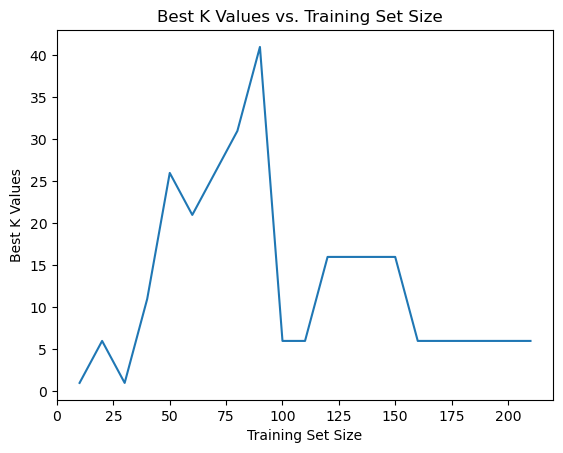

In [15]:
# plot best k values vs. training set size   
plt.plot(train_sizes, best_k, label = 'best_k')
plt.title('Best K Values vs. Training Set Size  ')
plt.xlabel('Training Set Size')
plt.ylabel('Best K Values')
plt.show()  

### Alternative Metrics for KNN

- Test KNN with different metrics (Minkowski, Manhattan, Chebyshev, Mahalanobis).
- Determine the best log10(p) for Minkowski distance.
- Summarize test errors in a table for the optimal k value.

#### Minkowski Distance.

Manhattan Distance with p = 1.

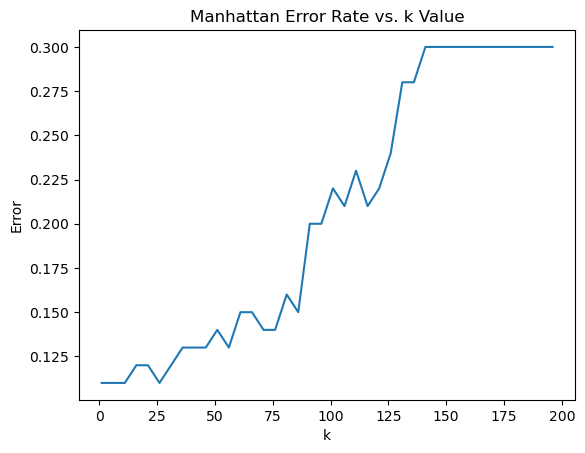

The optimal k for Manhattan metric is 1 with a test error 0.10999999999999999


In [16]:
# Replace the Euclidean metric with the following metrics and test them. Summarize the test errors (i.e., when k = k* ) in a table. 
# Use all of the training data and select the best k when {1,6,11,...,196}.

# for the table, create a dictionary & lists for metrics and corresponding test errors for future table

metric_error_dict = {
    'Metrics' : [],
    'K*' : [],
    'Test Error Rate' : []
}

# i. Minkowski Distance:
# A. which becomes Manhattan Distance with p = 1.
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    Manhattan_test_error = []
    # k belongs to the set {1,6,11,...,196}
    for i in range(1, 197, 5):
        knn = KNeighborsClassifier(n_neighbors=i, p=1, metric='manhattan')
        knn.fit(X_train,y_train)
        pred = knn.predict(X_test)
        Manhattan_test_error.append(1 - knn.score(X_test, y_test))
    
    # plot the error rate vs k values
    plt.plot(range(1, 197,5),Manhattan_test_error)
    plt.title('Manhattan Error Rate vs. k Value')
    plt.xlabel('k')
    plt.ylabel('Error')
    plt.show()
    
    min_Manhattan_error = min(Manhattan_test_error)
    min_Manhattan_error_index = Manhattan_test_error.index(min_Manhattan_error)
    Manhattan_best_k = 1 + min_Manhattan_error_index * 5
    
    # Summarize the best k value with the best test error:
    print("The optimal k for Manhattan metric is", Manhattan_best_k, "with a test error", min_Manhattan_error)

In [17]:
# Add the information to the table
metric_error_dict['Metrics'].append('Manhattan')
metric_error_dict['K*'].append(Manhattan_best_k)
rounded_Manhattan_error = round(min_Manhattan_error, 5)
metric_error_dict['Test Error Rate'].append(rounded_Manhattan_error)

# Display the current table
print(pd.DataFrame(metric_error_dict))

     Metrics  K*  Test Error Rate
0  Manhattan   1             0.11


With log10(p) in {0.1, 0.2, 0.3, ... ,1}.

In [18]:
# with log10(p) belongs to {0.1,0.2,0.3,...,1}. In this case, use the k* found for the Manhattan distance in 1(d)iA. 
# What is the best log10(p)?
log10_p_minkowski_err_rate = []
log10_p_value = []


with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    i = 0.1
    # log10(p) ∈ {0.1,0.2,0.3,...,1}
    while i <= 1:
        # train the model with the k* found for manhattan
        knn = KNeighborsClassifier(n_neighbors=Manhattan_best_k, p=10**i, metric = 'minkowski')
        knn.fit(X_train,y_train)
        # get the error
        log10_p_minkowski_err_rate.append(1 - knn.score(X_test, y_test))
        log10_p_value.append(i)
        i += 0.1
    
    # Get the table for log10(p) and its corresponding error rate
    p_error_result = {
        'log10(p)' : log10_p_value,
        'Error_Rate' : log10_p_minkowski_err_rate
    }
    print(pd.DataFrame(p_error_result))
    
    
    # Calculate the min error rate
    min_log10_p_err_rate = min(log10_p_minkowski_err_rate)
    min_log10_p_err_rate_index = log10_p_minkowski_err_rate.index(min_log10_p_err_rate)
    log10_p_optimal = 0.1 + min_log10_p_err_rate_index * 0.1
    
    print("\nThe best log10(p) is", log10_p_optimal, "with a test error", min_log10_p_err_rate)

   log10(p)  Error_Rate
0       0.1        0.13
1       0.2        0.13
2       0.3        0.13
3       0.4        0.14
4       0.5        0.14
5       0.6        0.12
6       0.7        0.11
7       0.8        0.11
8       0.9        0.11
9       1.0        0.11

The best log10(p) is 0.7000000000000001 with a test error 0.10999999999999999


In [19]:
# Add to the Metric summary table
metric_error_dict['Metrics'].append('Minkowski(log10(p)=0.7)')
metric_error_dict['K*'].append(Manhattan_best_k)
metric_error_dict['Test Error Rate'].append(min_log10_p_err_rate)

# Display the current table
print(pd.DataFrame(metric_error_dict))

                   Metrics  K*  Test Error Rate
0                Manhattan   1             0.11
1  Minkowski(log10(p)=0.7)   1             0.11


Chebyshev Distance With p -> infinity.

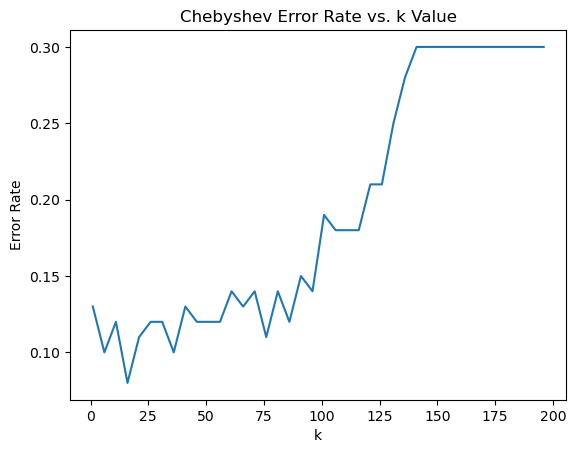

The most suitable K with Chebyshev metric is 16 with a test error 0.07999999999999996


In [20]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    p_inf_test_error = []
    for i in range(1, 197, 5):
        knn = KNeighborsClassifier(n_neighbors=i, metric='chebyshev')
        knn.fit(X_train,y_train)
        pred_i = knn.predict(X_test)
        p_inf_test_error.append(1 - knn.score(X_test, y_test))

    # Plot the error rate vesus the k values
    plt.plot(range(1, 197,5),p_inf_test_error)
    plt.title('Chebyshev Error Rate vs. k Value')
    plt.xlabel('k')
    plt.ylabel('Error Rate')
    plt.show()  

    # Find the optial k and the minimum error rate
    p_inf_min_error = min(p_inf_test_error)
    p_inf_min_error_index = p_inf_test_error.index(p_inf_min_error)
    min_err_k = 1 + p_inf_min_error_index * 5

    print("The most suitable K with Chebyshev metric is", min_err_k, "with a test error", p_inf_min_error)
    

In [21]:
# Add to the Metric summary table
metric_error_dict['Metrics'].append('Chebyshev')
metric_error_dict['K*'].append(min_err_k)
metric_error_dict['Test Error Rate'].append(p_inf_min_error)

# Display the current table
print(pd.DataFrame(metric_error_dict))

                   Metrics  K*  Test Error Rate
0                Manhattan   1             0.11
1  Minkowski(log10(p)=0.7)   1             0.11
2                Chebyshev  16             0.08


Mahalanobis Distance.

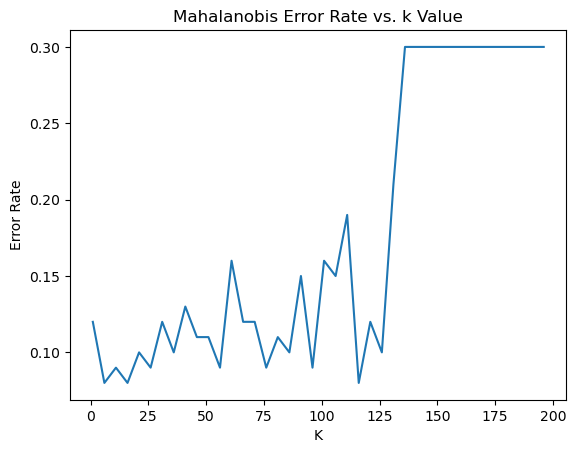

The most suitable K with Mahalanobis metric is 6 with a test error 0.07999999999999996


In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    mahalanobis_test_error_rate = []
    
    # train and fit the model with the corresponding metrics
    for i in range(1, 197, 5):
        # train the model
        knn = KNeighborsClassifier(n_neighbors=i, metric='mahalanobis', metric_params = {'VI': np.cov(X_train, rowvar=False)})
        knn.fit(X_train,y_train)
        # get the predictions and the errors
        pred_i = knn.predict(X_test)
        mahalanobis_test_error_rate.append(1 - knn.score(X_test, y_test))
    
    # plot the Mahalanobis test errors vs k's
    plt.plot(range(1, 197,5), mahalanobis_test_error_rate)
    plt.title('Mahalanobis Error Rate vs. k Value')
    plt.xlabel('K')
    plt.ylabel('Error Rate')
    plt.show()  
    
    
    # get the best error and the k
    min_mahalanobis_error = min(mahalanobis_test_error_rate)
    min_mahalanobis_error_index = mahalanobis_test_error_rate.index(min_mahalanobis_error)
    mahalanobis_optimal_k = 1 + min_mahalanobis_error_index * 5
    
    
    print("The most suitable K with Mahalanobis metric is", mahalanobis_optimal_k, "with a test error", min_mahalanobis_error)

In [23]:
# Add to the Metric summary table
metric_error_dict['Metrics'].append('Mahalanobis')
metric_error_dict['K*'].append(mahalanobis_optimal_k)
metric_error_dict['Test Error Rate'].append(min_mahalanobis_error)

# Display the final table
print(pd.DataFrame(metric_error_dict))

                   Metrics  K*  Test Error Rate
0                Manhattan   1             0.11
1  Minkowski(log10(p)=0.7)   1             0.11
2                Chebyshev  16             0.08
3              Mahalanobis   6             0.08


### Weighted Decision KNN

- Implement weighted voting with Euclidean, Manhattan, and Chebyshev distances.
- Report best test errors for various k values.

In [24]:
# The majority polling decision can be replaced by weighted decision, in which the
# weight of each point in voting is inversely proportional to its distance from the
# query/test data point. In this case, closer neighbors of a query point will have a greater influence than neighbors which are further away. 
# Use weighted voting with Euclidean, Manhattan, and Chebyshev distances and report the best test errors when k when {1,6,11,16,...,196}


with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    
    # Create a list of metrics that we will be generating results for 
    metrics = ['euclidean', 'manhattan', 'chebyshev']
    # Create the desired range for the k values
    k_vals_weighted_model = range(1, 197, 5)
    # Create an empty test error list to save the best test errors for each distance
    best_test_error_weighted = []
    # Create an empty list to save the optimal k value for each type of distance
    optimal_k_values_weighted = []
    
    # Weighted decision with Euclidean, Manhattan, and Chebyshev distance:
    for metric in metrics:
        
        # Create a test error rate list to include all the test errors for each type of distance
        test_error_rate_weighted = []

        # Test out all the k values in the desired range
        for k in k_vals_weighted_model:
            # Fit the model with the corresponding parameters
            knn = KNeighborsClassifier(n_neighbors=k, weights='distance', metric=metric)
            knn.fit(X_train, y_train)
    
            # Get the test error and append it to the error list
            test_error_rate_weighted.append(1 - knn.score(X_test, y_test))
    
        # After trying out all the k values, locate the minimum test error rate, find optimal k
        min_test_error_weighted = min(test_error_rate_weighted)
        best_test_error_weighted.append(min_test_error_weighted)
        
        min_test_error_weighted_index = test_error_rate_weighted.index(min_test_error_weighted)
        optimal_k_weighted = range(1, 197, 5)[min_test_error_weighted_index]
        optimal_k_values_weighted.append(optimal_k_weighted)
    
        # Print the statement about the optimal k value and the minimum test error
        print("The optimal K for", metric, "distance is", optimal_k_weighted, "with a test error of", min_test_error_weighted)
        
    
    # After looping through all the different types of distance, generate a table to save all the results for all 3 types of metrics(distances)
    k_test_error_table_weighted = {
        'Metrics' : metrics,
        'K*' : optimal_k_values_weighted,
        'Test Error Rate' : best_test_error_weighted
    }
    
    print(pd.DataFrame(k_test_error_table_weighted))


The optimal K for euclidean distance is 6 with a test error of 0.09999999999999998
The optimal K for manhattan distance is 26 with a test error of 0.09999999999999998
The optimal K for chebyshev distance is 16 with a test error of 0.10999999999999999
     Metrics  K*  Test Error Rate
0  euclidean   6             0.10
1  manhattan  26             0.10
2  chebyshev  16             0.11


### Training Error Rate

- Identify the lowest training error rate achieved in the project.

In [25]:
# What is the lowest training error rate you achieved
lowest_error_rate = min([min(metric_error_dict['Test Error Rate']), min(k_test_error_table_weighted['Test Error Rate'])])
print("The lowest training error rate is",lowest_error_rate)

The lowest training error rate is 0.07999999999999996


<!-- What is the lowest training error rate you achieved -->
This lowest training error rate I have achieved is 0.07999999999999996